# Lab 6: Convolutional Neural Networks


**Name(s):** Luke Voinov, Tiffany Nguyen, Emmanuel Garcia, Nimai Keshu

We use the Youtube Thumbnail Dataset:

https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset/data

This dataset contains the most successful thumbnails from over 90 youtube channels. There are 9 genres of videos with 10 - 15 channels in each genre

Much of the code in this dataset was adapted from Eric Larson, 12a. More Advanced CNN Techniques as TFData.ipynb:

https://github.com/eclarson/MachineLearningNotebooks/blob/master/12a.%20More%20Advanced%20CNN%20Techniques%20as%20TFData.ipynb

We denote this reference with (1)

### 1. Pre-processing

In [21]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)
# Python: 3.12.3

Pandas: 2.2.2
Numpy: 1.26.4


In [22]:
# This code was written by Github Copilot to get all the videos into one forlder for convenience
# Change the path and output path. make sure the input path goes into the images folder so that it could look through each folder inside it.
# Use the ouput path "all_images" for processing. Use the metadata.csv to pair each video with its genre.

import os
import shutil

path = r"C:\Users\lukev\Downloads\archive\thumbnails\images"
all_videos_path = r"C:\Users\lukev\Projects\ML in Python\Lab6\all_videos"

# Clear and recreate the all_videos folder to start fresh
if os.path.exists(all_videos_path):
    shutil.rmtree(all_videos_path)
os.makedirs(all_videos_path)

total_copied = 0
seen_filenames = set()

# Iterate through each subfolder in the path
for folder_name in os.listdir(path):
    folder_path = os.path.join(path, folder_name)
    
    # Only process if it's a directory
    if os.path.isdir(folder_path):
        # Get all files in this subfolder
        for file_name in os.listdir(folder_path):
            source_file = os.path.join(folder_path, file_name)
            
            # Only copy files, not subdirectories
            if os.path.isfile(source_file):
                # Check if we've seen this filename before
                if file_name in seen_filenames:
                    # Handle duplicate by adding folder prefix
                    name, ext = os.path.splitext(file_name)
                    new_file_name = f"{folder_name}_{file_name}"
                    destination_file = os.path.join(all_videos_path, new_file_name)
                    seen_filenames.add(new_file_name)
                else:
                    destination_file = os.path.join(all_videos_path, file_name)
                    seen_filenames.add(file_name)
                
                shutil.copy2(source_file, destination_file)
                total_copied += 1

print(f"Successfully copied {total_copied} files to:")
print(f"{all_videos_path}")

Successfully copied 2303 files to:
C:\Users\lukev\Projects\ML in Python\Lab6\all_videos


In [23]:
# this code is adapted from voinv_lab2.ipynb
# This code will list through every image in my folder and put it into a numpy array

import os
import numpy as np
from PIL import Image

# 'all' because there is no need to split between training and testing
source_dir = "all_videos"

# This code looks inside my 'all' folder and finds all my images
filelist = os.listdir(source_dir)
print(f"Loading {len(filelist)} images as numpy arrays...")

# Load all images into a list of numpy arrays
images = []
for f in filelist:
    fpath = os.path.join(source_dir, f) # this allow me to access each image path to store each image as an array
    img_array = np.array(Image.open(fpath))
    images.append(img_array)

# Convert list to numpy array
images = np.array(images)
print(f"Loaded {len(images)} images")
print(f"Image array shape: {images.shape}")

Loading 2303 images as numpy arrays...
Loaded 2303 images
Image array shape: (2303, 720, 1280, 3)
Loaded 2303 images
Image array shape: (2303, 720, 1280, 3)


In [24]:
# Code adapted from voinov_lab2.ipynb to scale image size down
# Adapted from github copilot to inlucde color channels
# Lareg images take longer to process
# We originally reduce each image to 64x64 and keep the color
# This code first reduces the pixel resolution of each image and then flattens each image

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

start_time = time.time()

# Get image dimensions from first image
print(f"Original image size: {images[0].shape}")

# convert to 32x32 pixels (RGB channels preserved automatically)
target_size = (64, 64)  # width, height only
print(f"Downsampling to: {target_size} (with 3 color channels)")

# number of features when flattened (64 * 64 * 3)
n_features = target_size[0] * target_size[1] * 3

# create a zero matrix that will store each image (rows) and has enough columns to store the number of features when each image is flattened
X = np.zeros((len(images), n_features), dtype=np.float32)

for i in range(len(images)):
    img = images[i]
    
    # Convert to RGB if image is grayscale or has alpha channel
    img_pil = Image.fromarray(img.astype(np.uint8))
    if img_pil.mode != 'RGB':
        img_pil = img_pil.convert('RGB')
    
    # resize to 32x32 (keeps 3 RGB channels)
    img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    
    # each row stores the flattened array (32*32*3 = 3072 features)
    X[i] = img_array.flatten()

h, w = target_size  # Set dimensions for later use
end_time = time.time()
print(f"\nProcessing completed in {end_time - start_time:.2f} seconds")
print(f"Dataset shape: {X.shape}")
print(f"Each image is {h}x{w}x3 = {n_features} features")

Original image size: (720, 1280, 3)
Downsampling to: (64, 64) (with 3 color channels)

Processing completed in 124.13 seconds
Dataset shape: (2303, 12288)
Each image is 64x64x3 = 12288 features

Processing completed in 124.13 seconds
Dataset shape: (2303, 12288)
Each image is 64x64x3 = 12288 features


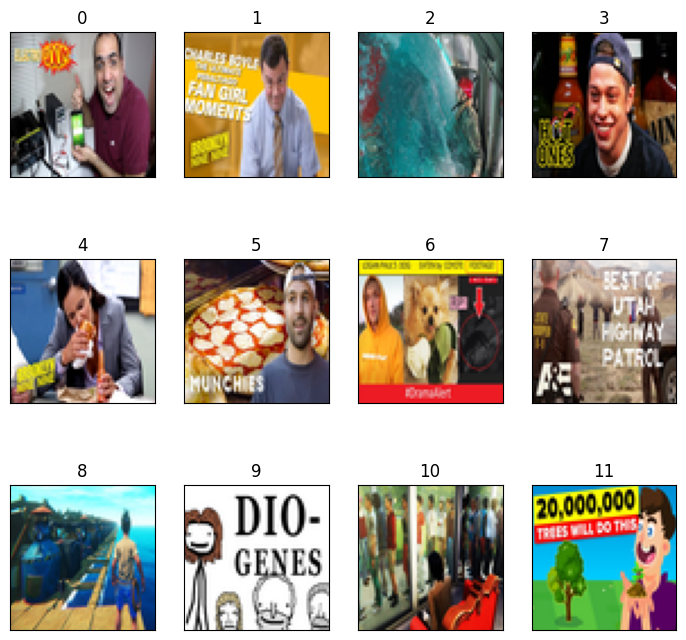

In [25]:
# Code adapted from voinov_lab2.ipynb to plot 12 images from our dataset

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of thumbnails"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Reshape to (h, w, 3) for color
        plt.imshow(images[i].reshape((h, w, 3)))
        plt.title(i, size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # Note that X uses the 32x32 image resolution


### 2. Preparation


2.1 *Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Mention why the data is similar to CIFAR and CIFAR's excellent business case (there isn't one). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*


YouTube could use this dataset to automatically classify youtube videos by genre. Social media companies are always trying to make their recommendation algorithms better. If the algorithm could know the particular genres a user preferred, it could dramatically narrow down which videos it should recommend to the user. Thumbnails, along with other features of a video such as title and creator, would provide enough information about a video's genre. While this dataset does provide each thumbnail's content creator and title, for the purposes of this lab we will just look at how thumbnails (X) can be used to predict genre (y). Furthermore, using this information to classify genres is recommended because user will only click on a video if the thumbnail, content creator, and title are appealing. Thus, a recommendation system trained on these features would see things close to how a user sees them; it would be close to the real-life context.

Rather than just choosing a metric based off our expectations, we will think through which one might be better and test all of them to make sure. 

The CNN would say the following about accuracy: "out of all the videos I was given, I classified this percentage as the correct genre". Thus, a score of 0.9 would mean that the CNN was able to classify 90% of the videos to their respective genres. This measurement could be meaningful. Because there are 9 genres in this dataset, class imbalance wouldn't be too large of an issue. If our CNN classified each video as only one genre, it would get a max accuracy of 1/9 = 11.1%. If it classified videos into 8 genres and ignored one completely, it could get near 90% accuracy. This wouldn't be too bad. 

Precision would tell us how many videos belong to the genre they were classified to. For every video classified into the entertainment genre, how many are actually entertainment? This means that precision would help us detect how many false positives there are in the data. Recall does the opposite and helps us predict how mnay false negatives there are.

Now it remains to consider what this system want to achieve and what conditions it should strive to avoid. The goal of this system is to correctly classify each thumbnail to its genre. Would it matter too much if the CNN incorrectly classified one genre (cooking, say) as a different one (gaming, say)? This would be an example of a false positive. If a user preferred gaming videos, and, while looking at their recommendations, saw a cooking video, would this be too harmful? Not at all, as long as the system classifies the majority of the thumbnails as 'gaming' and this cooking video is an outlier. At an extreme, however, the user would be severely dissatisfied if the system recommended mainly cooking videos. Therefore false positives should be punished to the extent that they're only rarely classified as such.

Would it matter if a 'gaming' video was consistently misclassified as non-gaming? This would be a false negative. That would mean that the user would never see that video from recommendations alone. This is a greater problem as it could have fueled greater engagement. While recommending the occassional cooking video could allow the system to catch changing preferences, the user is more likely to click on videos within their favorite genre. Since this is what the system wants, false negatives should be taken more seriosly than false positives.

Taken together, recall is slighly more important than precision because false negatives are more important to avoid. Precision also plays an important role though. Thus, F_beta would be a good measurement metric since it combines both precision and recall and allows us to weigh one as more imporatant than the other. Here, beta > 1, to give more importance to recall. Beta can be somehting between 2 or 3 because recall shouldn't have too much of an edge over precision. 

We choose F_3 and recall as our primary evalutation metrics. We will visualize with confusion matricies. 

### Note from Luke: I cannot yet use the evalutaion metric until y'all get to the 2 point problem on modeling. DO NOT do any evaluations - let me do those. 

### 3. Modeling